In [ ]:
pip install qiskit==0.43.1 qiskit-machine-learning==0.5.0 torch==2.1.2 torchvision==0.16.2 medmnist==2.0.2 sympy==1.13.1 protobuf==4.25.3 pillow==10.2.0 matplotlib "numpy < 1.24"


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:

In [ ]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import os

In [ ]:
def create_synthetic_breast_image(features, label, size=(64, 64)):
    """
    Tạo ảnh mô phỏng dựa trên các đặc trưng Mean, Std, Entropy
    """
    mean_val, std_val, entropy_val = features

    # Tạo noise pattern dựa trên entropy
    np.random.seed(int(entropy_val * 100) % 1000)
    base_noise = np.random.normal(0, std_val/100, size)

    # Tạo pattern dựa trên mean
    x, y = np.meshgrid(np.linspace(0, 1, size[0]), np.linspace(0, 1, size[1]))
    pattern = mean_val/255 + 0.3 * np.sin(entropy_val * x * np.pi) * np.cos(entropy_val * y * np.pi)

    # Kết hợp pattern và noise
    image = pattern + base_noise

    # Chuẩn hóa về [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Tạo đặc điểm cho từng loại
    if label == 1:  # malignant - thêm các vùng bất thường
        # Thêm các vùng có cường độ cao (tương tự khối u)
        center_x, center_y = size[0]//2, size[1]//2
        radius = min(size) // 6
        for i in range(size[0]):
            for j in range(size[1]):
                dist = np.sqrt((i - center_x)**2 + (j - center_y)**2)
                if dist < radius:
                    image[i, j] = min(255, image[i, j] + int(50 * (1 - dist/radius)))

    return image

In [ ]:
def plot_training_history(losses):
    """Vẽ biểu đồ loss trong quá trình training"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    """Vẽ confusion matrix đẹp hơn"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def evaluate_model_performance(y_true, y_pred):
    """Đánh giá chi tiết hiệu suất model"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0)
    }

    print("\n" + "="*50)
    print("MODEL PERFORMANCE EVALUATION")
    print("="*50)
    for metric, value in metrics.items():
        print(f"{metric:12}: {value:.4f}")
    print("="*50)

    return metrics

In [ ]:
def main():
    print("=" * 60)
    print("QUANTUM NEURAL NETWORK FOR BREAST CANCER CLASSIFICATION")
    print("=" * 60)

    # 1. Cấu hình QNN
    print("\n[1] Configuring Quantum Neural Network...")
    n_qubits = 3
    feature_map = ZZFeatureMap(feature_dimension=n_qubits)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2)  # Tăng reps để model phức tạp hơn
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

    # 2. Khởi tạo QNN
    qnn = TwoLayerQNN(n_qubits, feature_map, ansatz, quantum_instance=qi)
    model = TorchConnector(qnn)
    print("✓ Quantum Neural Network initialized successfully")

    # 3. Load và xử lý dữ liệu
    print("\n[2] Loading and preprocessing data...")
    try:
        df = pd.read_csv("chandoananhYKhoa_breastmnist.csv")
        print(f"✓ Dataset loaded: {len(df)} samples")
        print(f"   - Benign (0): {sum(df['Label'] == 0)} samples")
        print(f"   - Malignant (1): {sum(df['Label'] == 1)} samples")
    except FileNotFoundError:
        print("✗ Error: CSV file not found!")
        return

    # Chuẩn bị features và labels
    feature_cols = ['Mean', 'Std', 'Entropy']
    X = df[feature_cols].values.astype('float32')
    y = df['Label'].values.astype('float32')

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Chia tập train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"✓ Data split - Train: {len(X_train)}, Test: {len(X_test)}")
    # 4. Huấn luyện model
    print("\n[3] Training Quantum Neural Network...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()  # Tốt hơn cho binary classification

    # Chuyển đổi data sang tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

    losses = []
    epochs = 50  # Tăng số epoch
    batch_size = 10

    for epoch in range(epochs):
        epoch_loss = 0
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (len(X_train) // batch_size + 1)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1:2d}/{epochs}: Loss = {avg_loss:.6f}")

    print("✓ Training completed!")
    # 5. Đánh giá model
    print("\n[4] Evaluating model performance...")
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        test_predictions = model(X_test_tensor)
        test_pred_labels = (torch.sigmoid(test_predictions) > 0.5).int().numpy().flatten()

    # Tính metrics
    metrics = evaluate_model_performance(y_test, test_pred_labels)

    # 6. Tạo và lưu ảnh được phân loại
    print("\n[5] Generating classified images...")
    output_dir = "classified_breast_images"
    os.makedirs(output_dir, exist_ok=True)

    label_names = {0: "Benign", 1: "Malignant"}

    for i in range(min(20, len(X_test))):  # Tạo tối đa 20 ảnh mẫu
        # Lấy features gốc (trước khi chuẩn hóa)
        original_features = df.iloc[i][feature_cols].values
        true_label = int(y_test[i])
        pred_label = int(test_pred_labels[i])

        # Tạo ảnh mô phỏng
        synthetic_image = create_synthetic_breast_image(original_features, true_label)

        # Tạo visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Hiển thị ảnh
        ax1.imshow(synthetic_image, cmap='gray')
        ax1.set_title(f'Sample {i+1}\nTrue: {label_names[true_label]}\nPred: {label_names[pred_label]}')
        ax1.axis('off')

        # Hiển thị features
        features_text = f"""Features:
Mean: {original_features[0]:.2f}
Std: {original_features[1]:.2f}
Entropy: {original_features[2]:.2f}

Classification:
True Label: {label_names[true_label]}
Predicted: {label_names[pred_label]}
Confidence: {torch.sigmoid(test_predictions[i]).item():.3f}
        """

        ax2.text(0.1, 0.5, features_text, transform=ax2.transAxes,
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax2.axis('off')

        # Lưu ảnh
        filename = f"sample_{i+1:02d}_true{true_label}_pred{pred_label}.png"
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches='tight')
        plt.close()

    print(f"✓ Generated {min(20, len(X_test))} classified images in '{output_dir}' folder")

    # 7. Vẽ các biểu đồ phân tích
    print("\n[6] Generating analysis plots...")

    # Training loss
    plot_training_history(losses)

    # Confusion matrix
    plot_confusion_matrix(y_test, test_pred_labels)

    # Feature distribution
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(feature_cols):
        plt.subplot(1, 3, i+1)
        benign_data = df[df['Label'] == 0][feature]
        malignant_data = df[df['Label'] == 1][feature]

        plt.hist(benign_data, alpha=0.7, label='Benign', bins=20)
        plt.hist(malignant_data, alpha=0.7, label='Malignant', bins=20)
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature} Distribution')
        plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"• Model Accuracy: {metrics['Accuracy']:.1%}")
    print(f"• Images saved in: {output_dir}/")
    print(f"• Total samples processed: {len(df)}")
    print("="*60)


QUANTUM NEURAL NETWORK FOR BREAST CANCER CLASSIFICATION

[1] Configuring Quantum Neural Network...
✓ Quantum Neural Network initialized successfully

[2] Loading and preprocessing data...
✓ Dataset loaded: 156 samples
   - Benign (0): 42 samples
   - Malignant (1): 114 samples
✓ Data split - Train: 124, Test: 32

[3] Training Quantum Neural Network...


<ipython-input-35-2a6ecd7567a8>:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


   Epoch 10/50: Loss = 0.658675
   Epoch 20/50: Loss = 0.644282
   Epoch 30/50: Loss = 0.638222
   Epoch 40/50: Loss = 0.635635
   Epoch 50/50: Loss = 0.633977
✓ Training completed!

[4] Evaluating model performance...

MODEL PERFORMANCE EVALUATION
Accuracy    : 0.5938
Precision   : 0.6923
Recall      : 0.7826
F1 Score    : 0.7347

[5] Generating classified images...
✓ Generated 20 classified images in 'classified_breast_images' folder

[6] Generating analysis plots...


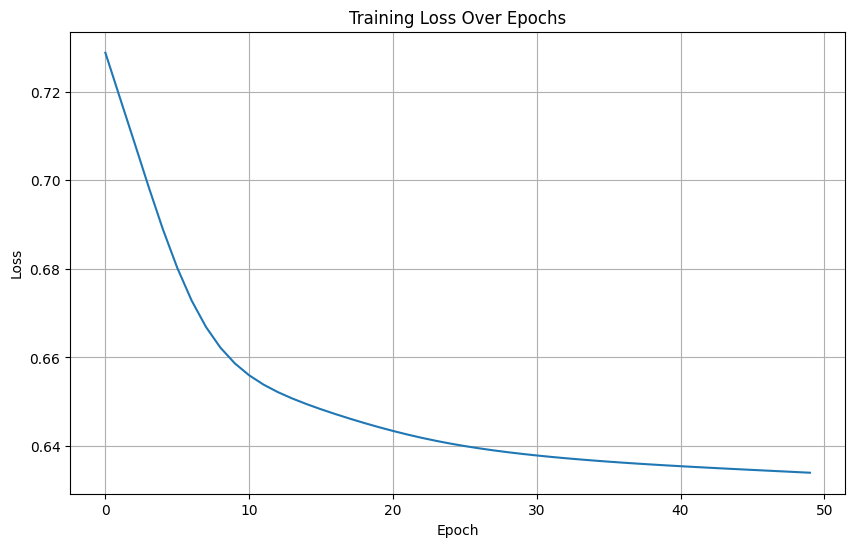

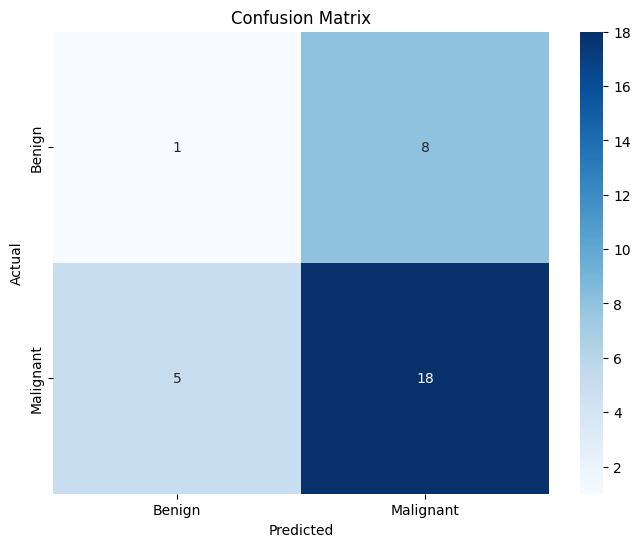

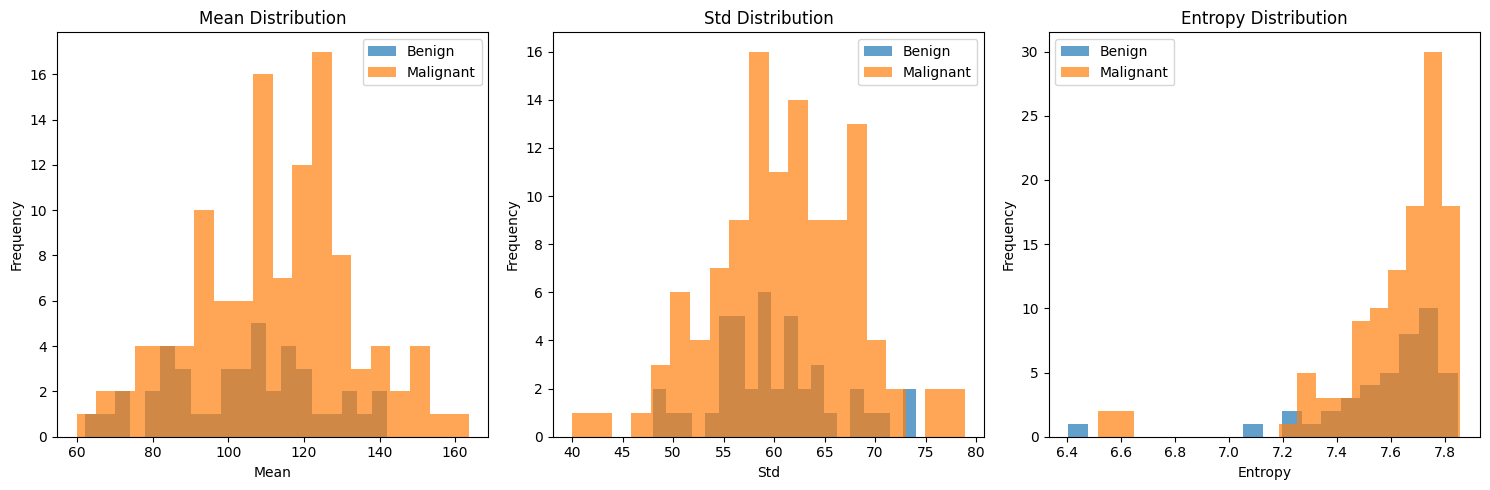


ANALYSIS COMPLETED SUCCESSFULLY!
• Model Accuracy: 59.4%
• Images saved in: classified_breast_images/
• Total samples processed: 156


In [ ]:
if __name__ == "__main__":
    main()